In [1]:
from importlib.metadata import version
from medmnist import BreastMNIST
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import os
from PIL import Image
import numpy as np

print("medmnist version: " + str(version("medmnist")))
print("matplotlib version: " + str(version("matplotlib")))
print("torch version: " + str(torch.__version__))
print("torchvision version: " + str(version("torchvision")))
print("sklearn version: " + str(version("scikit-learn")))
print("PIL version: " + str(version("pillow")))
print("numpy version: " + str(np.__version__))

medmnist version: 3.0.2
matplotlib version: 3.10.8
torch version: 2.9.1
torchvision version: 0.24.1
sklearn version: 1.8.0
PIL version: 12.1.0
numpy version: 2.4.1


## About the data

This project uses the **BreastMNIST** dataset from the [MedMNIST project](https://medmnist.com/), a curated benchmark collection of lightweight biomedical image datasets designed for machine learning research.

### Original data source

The breast ultrasound images were originally collected from clinical ultrasound examinations and compiled from publicly available medical imaging repositories used in prior academic studies on breast lesion classification. The raw images vary in:

- Spatial resolution
- Intensity scale
- Aspect ratio
- Acquisition devices and clinical settings

MedMNIST aggregates these sources and provides a standardized version suitable for machine learning benchmarking.

### Dataset composition

The BreastMNIST dataset contains:

- **780 grayscale breast ultrasound images**
- **2 classes**:
  - 0: normal / benign  
  - 1: malignant  

In this project, the **128×128 pixel version** of the dataset is used.

### Standardization and preprocessing by MedMNIST

MedMNIST applies the following preprocessing steps to all images:

1. Conversion to grayscale (single channel)
2. Center cropping or padding to preserve anatomical content
3. Resizing to fixed square resolutions (28×28, 64×64, 128×128, or 224×224)
4. Pixel intensity normalization to the range [0, 255]
5. Storage in NumPy-compatible format with predefined train, validation, and test splits

These steps ensure that all samples share the same shape and scale, enabling reproducible experiments and fair model comparison.

### How to download the dataset

The dataset is automatically downloaded using the official MedMNIST Python package:

```python
from medmnist import BreastMNIST

dataset = BreastMNIST(
    split = "train",
    size = 128,
    download = True
)
```

The files are cached locally after the first download.

References

Jiancheng Yang, Rui Shi, Donglai Wei, Zequan Liu, Lin Zhao, Bilian Ke, Hanspeter Pfister, Bingbing Ni. "MedMNIST v2: A large-scale lightweight benchmark for 2D and 3D biomedical image classification." _Scientific Data_, 2023.

Jiancheng Yang, Rui Shi, Bingbing Ni. "MedMNIST Classification Decathlon: A Lightweight AutoML Benchmark for Medical Image Analysis." _IEEE 18th International Symposium on Biomedical Imaging (ISBI)_, 2021.

In [2]:
# Project setup
# Set seeds for reproducibility
def set_seed(seed = 1601):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(1601)

# Detect best device
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

# Force CPU usage for deterministic results (comment out for faster non-deterministic training)
device = torch.device('cpu')

print(f"Using device: {device}")

# Mention object types to deal with pesky Pylance warnings:
train_loader: DataLoader
val_loader: DataLoader
test_loader: DataLoader

Using device: cpu


## Exploratory data analysis

In [3]:
# Use this code to download all the images in png format to the data folder
def save_medmnist_images(split_name):
    """Save MedMNIST images to data folder organized by split and label. The images are PIL objects."""
    # Load dataset
    dataset = BreastMNIST(split = split_name, download = True, size = 128)
  
    os.makedirs(f'../data/{split_name}/benign', exist_ok = True)
    os.makedirs(f'../data/{split_name}/malignant', exist_ok = True)

    # Save images
    for idx in range(len(dataset)):
        img, label = dataset[idx]
        label_name = 'malignant' if label[0] == 1 else 'benign'
       
        # Save PIL objects at png files
        img.save(f'../data/{split_name}/{label_name}/img_{idx:04d}.png')
    
    print(f"Saved {len(dataset)} {split_name} images\n")

# Save all splits
save_medmnist_images('train')
save_medmnist_images('val')
save_medmnist_images('test')

Saved 546 train images

Saved 78 val images

Saved 156 test images



### Dataset statistics

In [4]:
def print_dataset_summary():
    """Print comprehensive dataset statistics"""
    print("=" * 40)
    print("BreastMNIST 128 x 128")
    print("=" * 40)
    
    splits = ['train', 'val', 'test']
    total_images = 0
    
    for split in splits:
        dataset = BreastMNIST(split = split, download = True, size = 128)
        img, label = dataset[0]
        
        # Convert to numpy array
        img_array = np.array(img)
        
        print(f"\n{split} set:")
        print(f"  Total images: {len(dataset)}")
        print(f"  Image shape: {img_array.shape}")
        print(f"  Image dtype: {img_array.dtype}")
        print(f"  Pixel range: [{img_array.min()}, {img_array.max()}]")
        
        labels = [dataset[i][1][0] for i in range(len(dataset))]
        benign = labels.count(0)
        malignant = labels.count(1)
        print(f"  benign: {benign} ({benign/len(dataset)*100:.1f}%)")
        print(f"  malignant: {malignant} ({malignant/len(dataset)*100:.1f}%)")
        
        total_images += len(dataset)
    
    print(f"\nTotal dataset size: {total_images} images")
    print("=" * 40)

print_dataset_summary()

BreastMNIST 128 x 128

train set:
  Total images: 546
  Image shape: (128, 128)
  Image dtype: uint8
  Pixel range: [12, 239]
  benign: 147 (26.9%)
  malignant: 399 (73.1%)

val set:
  Total images: 78
  Image shape: (128, 128)
  Image dtype: uint8
  Pixel range: [2, 219]
  benign: 21 (26.9%)
  malignant: 57 (73.1%)

test set:
  Total images: 156
  Image shape: (128, 128)
  Image dtype: uint8
  Pixel range: [1, 240]
  benign: 42 (26.9%)
  malignant: 114 (73.1%)

Total dataset size: 780 images


### Class distribution by split

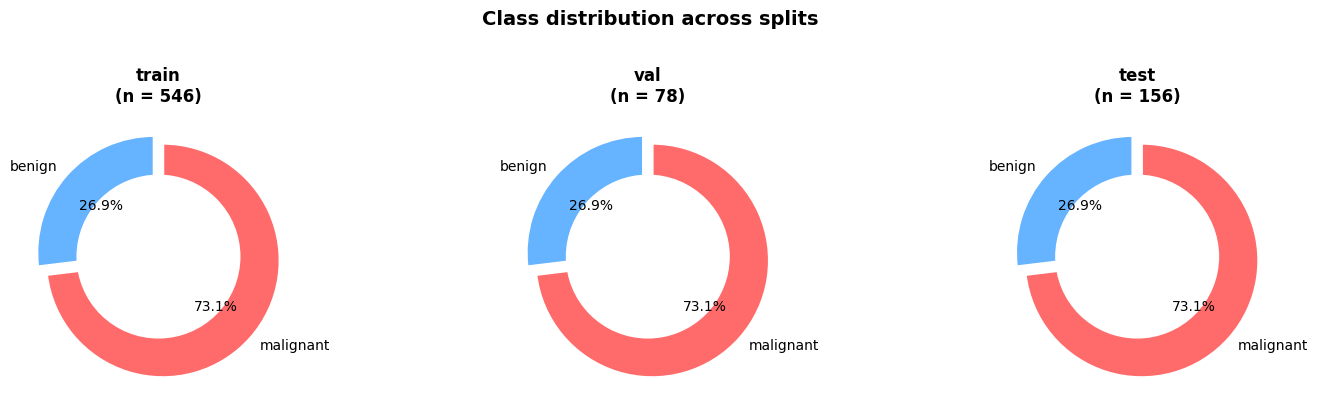


Class distribution summary:
--------------------------------------------------
train - benign: 147 (26.9%), malignant: 399 (73.1%)
val   - benign:  21 (26.9%), malignant:  57 (73.1%)
test  - benign:  42 (26.9%), malignant: 114 (73.1%)


In [5]:
def plot_class_distribution():
    """Plot class distribution across splits using donut charts"""
    splits = ['train', 'val', 'test']
    
    fig, axes = plt.subplots(1, 3, figsize = (15, 4))
    
    for idx, split in enumerate(splits):
        dataset = BreastMNIST(split = split, download = True, size = 128)
        
        # Count classes
        labels = [dataset[i][1][0] for i in range(len(dataset))]
        benign = labels.count(0)
        malignant = labels.count(1)
        
        # Create donut chart
        sizes = [benign, malignant]
        colors = ['#66b3ff', '#ff6b6b']
        explode = (0.05, 0.05)
        
        axes[idx].pie(sizes, explode = explode, labels = ['benign', 'malignant'], 
                     colors = colors, autopct = '%1.1f%%', startangle = 90,
                     wedgeprops={'edgecolor': 'white', 'linewidth': 2})
        
        # Draw circle for donut
        centre_circle = plt.Circle((0,0), 0.70, fc = 'white')
        axes[idx].add_artist(centre_circle)
        
        axes[idx].set_title(f'{split}\n(n = {len(dataset)})', fontsize = 12, fontweight = 'bold')
    
    fig.suptitle('Class distribution across splits', fontsize = 14, fontweight = 'bold', y = 1.02)
    fig.tight_layout()
    plt.show()
    
    # Print summary
    print("\nClass distribution summary:")
    print("-" * 50)
    for split in splits:
        dataset = BreastMNIST(split = split, download = True)
        labels = [dataset[i][1][0] for i in range(len(dataset))]
        benign = labels.count(0)
        malignant = labels.count(1)
        print(f"{split:5} - benign: {benign:3} ({benign/len(dataset)*100:.1f}%), "
              f"malignant: {malignant:3} ({malignant/len(dataset)*100:.1f}%)")

plot_class_distribution()

### Sample images

PIL size: (128, 128)
PIL Mode: L


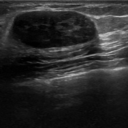

In [6]:
# Single sample
img = Image.open('../data/test/malignant/img_0001.png')

# PIL object size
print(f"PIL size: {img.size}")

# Get the mode (L = grayscale, RGB = color)
print(f"PIL Mode: {img.mode}")

img

In [7]:
# Array shape
img_array = np.array(img)

print(f"PIL as array shape: {img_array.shape}")

PIL as array shape: (128, 128)


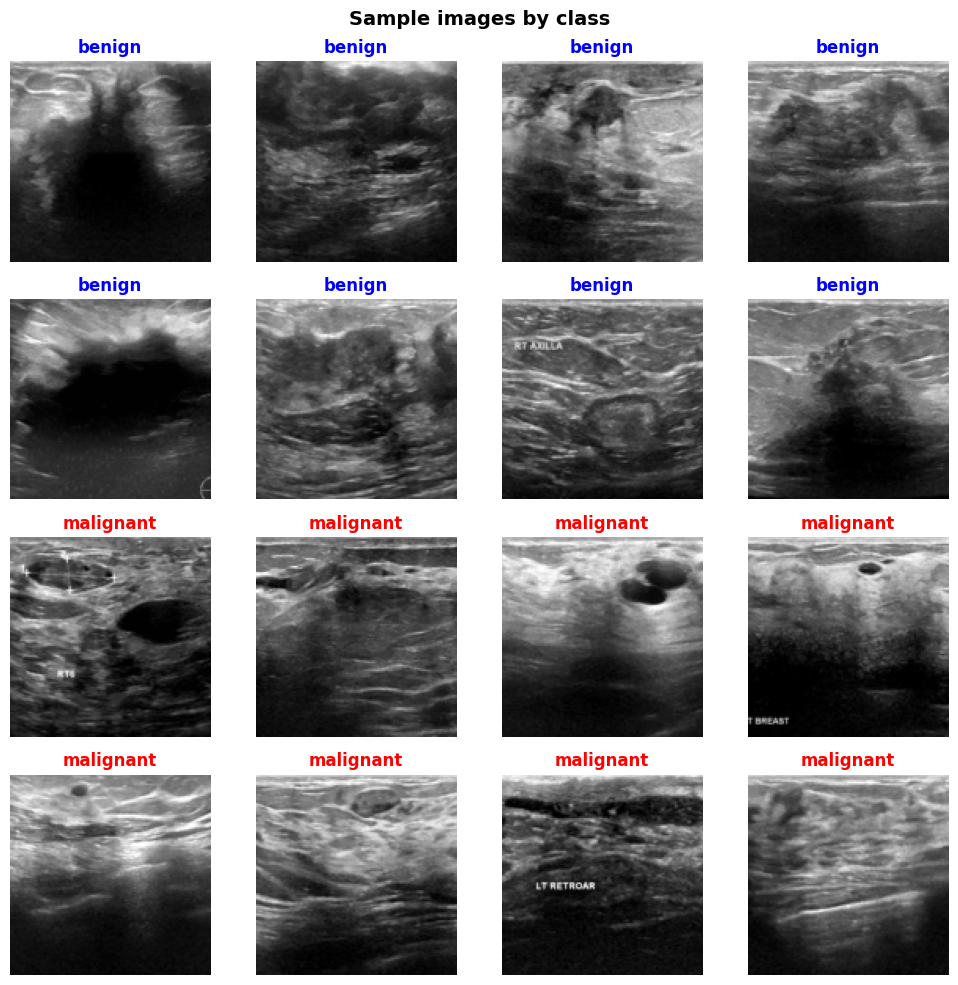

In [8]:
def plot_sample_images(n_samples = 16):
    """Display random sample of images from each class"""
    train_dataset = BreastMNIST(split = 'train', download = True, size = 128)
    
    # Get samples from each class
    benign_indices = [i for i in range(len(train_dataset)) if train_dataset[i][1][0] == 0]
    malignant_indices = [i for i in range(len(train_dataset)) if train_dataset[i][1][0] == 1]
    
    # Random samples
    np.random.seed(42)
    benign_samples = np.random.choice(benign_indices, n_samples//2, replace = False)
    malignant_samples = np.random.choice(malignant_indices, n_samples//2, replace = False)
    
    fig, axes = plt.subplots(4, 4, figsize = (10, 10))
    
    for idx, ax in enumerate(axes.flat):
        if idx < n_samples//2:
            img, _ = train_dataset[benign_samples[idx]]
            title = 'benign'
            color = 'blue'
        else:
            img, _ = train_dataset[malignant_samples[idx - n_samples//2]]
            title = 'malignant'
            color = 'red'
        
        ax.imshow(img, cmap = 'gray')
        ax.set_title(title, color = color, fontweight = 'bold')
        ax.axis('off')
    
    fig.suptitle('Sample images by class', fontsize = 14, fontweight = 'bold')
    fig.tight_layout()
    plt.show()

plot_sample_images()

### Intensity distribution

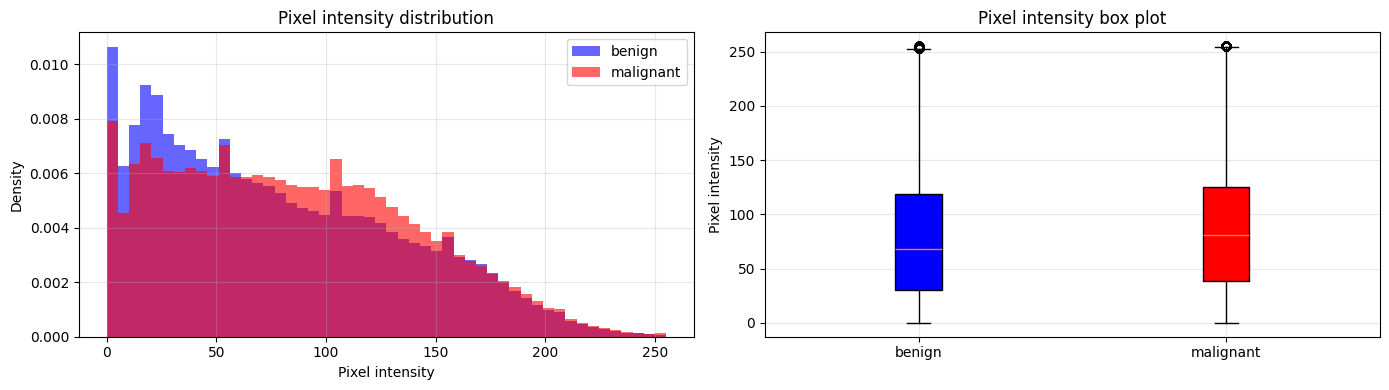


Pixel intensity statistics
--------------------------------------------------
benign    - mean: 78.19, std: 56.03
malignant - mean: 85.53, std: 54.96


In [9]:
def plot_pixel_intensity_distribution():
    """Compare pixel intensity distributions between classes"""
    train_dataset = BreastMNIST(split = 'train', download = True, size = 128)
    
    benign_pixels = []
    malignant_pixels = []
    
    for i in range(len(train_dataset)):
        img, label = train_dataset[i]
        # Convert to numpy array first
        img_array = np.array(img)
        
        if label[0] == 0:
            benign_pixels.extend(img_array.flatten())
        else:
            malignant_pixels.extend(img_array.flatten())
    
    fig, axes = plt.subplots(1, 2, figsize = (14, 4))
    
    # Histogram
    axes[0].hist(benign_pixels, bins = 50, alpha = 0.6, label = 'benign', color = 'blue', density = True)
    axes[0].hist(malignant_pixels, bins = 50, alpha = 0.6, label = 'malignant', color = 'red', density = True)
    axes[0].set_xlabel('Pixel intensity')
    axes[0].set_ylabel('Density')
    axes[0].set_title('Pixel intensity distribution')
    axes[0].legend()
    axes[0].grid(alpha = 0.3)
    
    # Box plot
    data = [benign_pixels, malignant_pixels]
    bp = axes[1].boxplot(data, tick_labels = ['benign', 'malignant'], patch_artist = True)
    bp['boxes'][0].set_facecolor('blue')
    bp['boxes'][1].set_facecolor('red')
    axes[1].set_ylabel('Pixel intensity')
    axes[1].set_title('Pixel intensity box plot')
    axes[1].grid(alpha = 0.3)
    
    fig.tight_layout()
    plt.show()
    
    # Statistics
    print("\nPixel intensity statistics")
    print("-" * 50)
    print(f"benign    - mean: {np.mean(benign_pixels):.2f}, std: {np.std(benign_pixels):.2f}")
    print(f"malignant - mean: {np.mean(malignant_pixels):.2f}, std: {np.std(malignant_pixels):.2f}")

plot_pixel_intensity_distribution()

### Brightness comparison

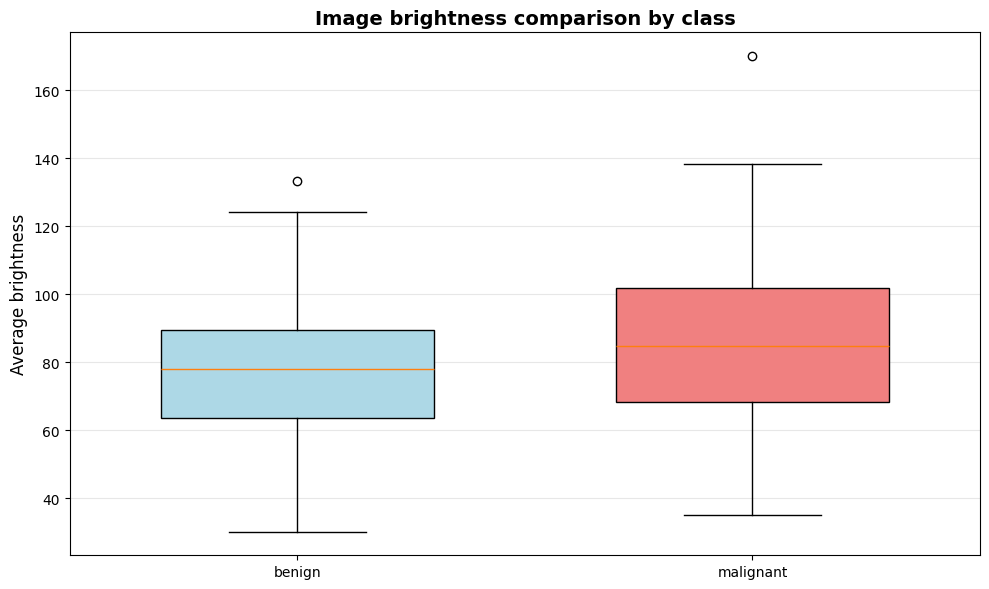


Brightness statistics:
benign    - mean: 78.19, std: 19.67
malignant - mean: 85.53, std: 21.92


In [10]:
def plot_brightness_comparison():
    """Compare average brightness between classes"""
    train_dataset = BreastMNIST(split = 'train', download = True, size = 128)
    
    benign_brightness = []
    malignant_brightness = []
    
    for i in range(len(train_dataset)):
        img, label = train_dataset[i]
        # Convert to numpy array first
        img_array = np.array(img)
        brightness = np.mean(img_array)
        
        if label[0] == 0:
            benign_brightness.append(brightness)
        else:
            malignant_brightness.append(brightness)
    
    fig, ax = plt.subplots(figsize = (10, 6))
    
    positions = [1, 2]
    bp = ax.boxplot([benign_brightness, malignant_brightness], 
                     positions = positions,
                     widths = 0.6,
                     patch_artist = True,
                     tick_labels = ['benign', 'malignant'])
    
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('lightcoral')
    
    ax.set_ylabel('Average brightness', fontsize = 12)
    ax.set_title('Image brightness comparison by class', fontsize = 14, fontweight = 'bold')
    ax.grid(axis = 'y', alpha = 0.3)
    
    fig.tight_layout()
    plt.show()
    
    print(f"\nBrightness statistics:")
    print(f"benign    - mean: {np.mean(benign_brightness):.2f}, std: {np.std(benign_brightness):.2f}")
    print(f"malignant - mean: {np.mean(malignant_brightness):.2f}, std: {np.std(malignant_brightness):.2f}")

plot_brightness_comparison()

## Data preprocessing

In [11]:
# Load and preprocess; converts to floating-point (0.0 to 1.0) and reshapes into (C, H, W) format
train_dataset = BreastMNIST(split = 'train', download = True, size = 128, transform = transforms.ToTensor())
val_dataset = BreastMNIST(split = 'val', download = True, size = 128, transform = transforms.ToTensor())
test_dataset = BreastMNIST(split = 'test', download = True, size = 128, transform = transforms.ToTensor())

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

Train: 546, Val: 78, Test: 156


In [12]:
# Look at raw values
train_dataset[0]

(tensor([[[0.6157, 0.6235, 0.6588,  ..., 0.6706, 0.6863, 0.6824],
          [0.6000, 0.6000, 0.6078,  ..., 0.6784, 0.6980, 0.7137],
          [0.7216, 0.6980, 0.6824,  ..., 0.7216, 0.7255, 0.7333],
          ...,
          [0.2745, 0.2980, 0.2902,  ..., 0.1490, 0.1490, 0.1451],
          [0.2196, 0.2196, 0.2549,  ..., 0.1686, 0.1412, 0.1333],
          [0.1882, 0.1725, 0.1882,  ..., 0.2078, 0.2078, 0.1804]]]),
 array([1]))

In [13]:
# Get one image, look at dimensions and size
img, label = train_dataset[0]

# Tensor shape
print(f"Tensor shape: {img.shape}")  # e.g., torch.Size([1, 28, 28])
print(f"Tensor dimensions: C = {img.shape[0]}, H = {img.shape[1]}, W = {img.shape[2]}")

# Memory size in bytes
print(f"Tensor memory: {img.element_size() * img.nelement()} bytes")

Tensor shape: torch.Size([1, 128, 128])
Tensor dimensions: C = 1, H = 128, W = 128
Tensor memory: 65536 bytes


In [14]:
# Create data loaders
def make_loaders():
    set_seed(1601)
    return (
        DataLoader(train_dataset, batch_size = 32, shuffle = True, num_workers = 0),
        DataLoader(val_dataset, batch_size = 32, shuffle = False, num_workers = 0),
        DataLoader(test_dataset, batch_size = 32, shuffle = False, num_workers = 0),
    )

## Convolutional neural network (CNN) setup

### Data flow and dimensions (128×128 images)

| Layer                 | Input dim      | Output dim     | Purpose/function                          |
| :---                  | :---           | :---           | :---                                      |
| **Input**             |  (1, 128, 128) |  (1, 128, 128) | Grayscale input image.                    |
| **Conv1 + BN + ReLU** |  (1, 128, 128) | (16, 128, 128) | Extracts basic patterns (edges/lines)     |
| **MaxPool1**          | (16, 128, 128) |   (16, 64, 64) | Reduce spatial resolution by half         |
| **Conv2 + BN + ReLU** |   (16, 64, 64) |   (32, 64, 64) | Learn more complex textures and shapes    |
| **MaxPool2**          |   (32, 64, 64) |   (32, 32, 32) | Reduces spatial size further              |
| **Conv Dropout**      |   (32, 32, 32) |   (32, 32, 32) | Regularize convolutional features         |
| **Conv3 + BN + ReLU** |   (32, 32, 32) |   (64, 32, 32) | Extract higher-level features             |
| **MaxPool3**          |   (64, 32, 32) |   (64, 16, 16) | Halves spatial dimensions                 |
| **Conv4 + BN + ReLU** |   (64, 16, 16) |  (128, 16, 16) | Extracts most complex features            |
| **MaxPool4**          |  (128, 16, 16) |    (128, 8, 8) | Final spatial reduction                   |
| **AdaptiveAvgPool**   |    (128, 8, 8) |    (128, 4, 4) | Convert feature maps to fixed size        |
| **Flatten**           |    (128, 4, 4) |           2048 | Convert feature maps into vector          |
| **FC Dropout**.       |           2048 |           2048 | Reduce overfitting                        |
| **Fully Connected**   |           2048 |              2 | Output class scores (benign vs malignant) |

In [15]:
# Create CNN model, allow conv and fc dropout rates to be set manually
class BreastCNN(nn.Module):
    def __init__(self, conv_drop_rate = 0.0, fc_drop_rate = 0.3):
        super().__init__()

        # Block 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size = 3, padding = 1)
        self.bn1 = nn.BatchNorm2d(16)

        # Block 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(32)

        # Block 3
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.bn3 = nn.BatchNorm2d(64)

        # Block 4
        self.conv4 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1)
        self.bn4 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)

        # Dropouts
        self.drop_conv = nn.Dropout2d(p = conv_drop_rate)
        self.drop_fc = nn.Dropout(p = fc_drop_rate)

        # Adaptive pooling for input-size independence
        self.gap = nn.AdaptiveAvgPool2d((4, 4))

        # Fully connected
        self.fc = nn.Linear(128 * 4 * 4, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        x = self.drop_conv(x)

        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = self.gap(x)

        x = x.view(x.size(0), -1)

        x = self.drop_fc(x)
        x = self.fc(x)

        return x

# Function to initialize model, loss, and optimizer
def setup_experiment(c_drop, f_drop, w_decay, lr = 1e-3):
    model = BreastCNN(conv_drop_rate = c_drop, fc_drop_rate = f_drop).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = w_decay)
    return model, criterion, optimizer

In [16]:
def run_epoch(model, loader, criterion, optimizer = None):
    if optimizer:
        model.train()
    else:
        model.eval()

    running_loss = 0.0

    total = 0
    correct = 0

    tp = 0
    fp = 0
    fn = 0

    context = torch.enable_grad() if optimizer else torch.no_grad()

    with context:
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device).view(-1).long()

            if optimizer:
                optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            if optimizer:
                loss.backward()
                optimizer.step()

            running_loss += loss.item()

            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Binary classification metrics (positive class = 1)
            tp += ((predicted == 1) & (labels == 1)).sum().item()
            fp += ((predicted == 1) & (labels == 0)).sum().item()
            fn += ((predicted == 0) & (labels == 1)).sum().item()

    avg_loss = running_loss / len(loader)
    accuracy = 100.0 * correct / total

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    return avg_loss, accuracy, precision, recall, f1

In [17]:
def train_model(model, optimizer, criterion, version_name, num_epochs = 30, use_scheduler = True):
    best_val_f1 = 0.0
    save_path = f"best_model_{version_name}.pth"

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    val_precisions, val_recalls, val_f1s = [], [], []

    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode = 'max', factor = 0.5, patience = 5
        )

    if use_scheduler:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode = 'max',      # maximize val F1
        factor = 0.5,      # halve the LR when triggered
        patience = 3,      # wait 3 epochs with no improvement
        threshold = 1e-3,  # require at least 0.001 improvement to count as "better"
    )

    print(f"Training {version_name}...")
    print("-" * 110)

    for epoch in range(num_epochs):
        train_loss, train_acc, _, _, _ = run_epoch(
            model, train_loader, criterion, optimizer
        )

        val_loss, val_acc, val_prec, val_rec, val_f1 = run_epoch(
            model, val_loader, criterion
        )

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        val_precisions.append(val_prec)
        val_recalls.append(val_rec)
        val_f1s.append(val_f1)

        if use_scheduler:
            old_lr = optimizer.param_groups[0]['lr']
            scheduler.step(val_f1)
            new_lr = optimizer.param_groups[0]['lr']
            if new_lr != old_lr:
                print(f"  Learning rate reduced: {old_lr:.2e} -> {new_lr:.2e}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save(model.state_dict(), save_path)
            status = "✓ Saved"
        else:
            status = ""

        print(
            f"Epoch {epoch+1:02d} | "
            f"Train acc: {train_acc:5.1f}% Loss: {train_loss:.4f} | "
            f"Val acc: {val_acc:5.1f}% Loss: {val_loss:.4f} | "
            f"P: {val_prec:.3f} R: {val_rec:.3f} F1: {val_f1:.3f} {status}"
        )

    print("-" * 110)

    print(f"\nTraining summary for {version_name}:")
    print(f"  Best val F1: {best_val_f1:.4f}")
    print(f"  Final val accuracy: {val_accs[-1]:.2f}%")
    print(f"  Final val precision: {val_precisions[-1]:.4f}")
    print(f"  Final val recall: {val_recalls[-1]:.4f}")

    # Plotting
    epochs_range = range(1, num_epochs + 1)

    plt.figure(figsize = (14, 5))

    # Accuracy plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, train_accs, label = 'Train')
    plt.plot(epochs_range, val_accs, label = 'Val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{version_name} Accuracy')
    plt.legend()
    plt.grid(alpha = 0.3)

    # Loss plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, train_losses, label = 'Train')
    plt.plot(epochs_range, val_losses, label = 'Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{version_name} Loss')
    plt.legend()
    plt.grid(alpha = 0.3)

    # F1 plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, val_f1s, label = 'Val F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.title(f'{version_name} Validation F1')
    plt.legend()
    plt.grid(alpha = 0.3)

    plt.tight_layout()
    plt.show()

## Model training

### Model 1

Training V1_Baseline...
--------------------------------------------------------------------------------------------------------------
Epoch 01 | Train acc:  71.2% Loss: 0.6779 | Val acc:  26.9% Loss: 1.0910 | P: 0.000 R: 0.000 F1: 0.000 
Epoch 02 | Train acc:  81.3% Loss: 0.4156 | Val acc:  30.8% Loss: 1.0171 | P: 1.000 R: 0.053 F1: 0.100 ✓ Saved
Epoch 03 | Train acc:  85.7% Loss: 0.3811 | Val acc:  52.6% Loss: 0.7106 | P: 0.955 R: 0.368 F1: 0.532 ✓ Saved
Epoch 04 | Train acc:  85.9% Loss: 0.3464 | Val acc:  80.8% Loss: 0.3880 | P: 0.957 R: 0.772 F1: 0.854 ✓ Saved
Epoch 05 | Train acc:  88.5% Loss: 0.3351 | Val acc:  82.1% Loss: 0.3612 | P: 0.906 R: 0.842 F1: 0.873 ✓ Saved
Epoch 06 | Train acc:  84.1% Loss: 0.3648 | Val acc:  84.6% Loss: 0.2572 | P: 0.895 R: 0.895 F1: 0.895 ✓ Saved
Epoch 07 | Train acc:  85.7% Loss: 0.3108 | Val acc:  93.6% Loss: 0.2231 | P: 0.964 R: 0.947 F1: 0.956 ✓ Saved
Epoch 08 | Train acc:  91.0% Loss: 0.2456 | Val acc:  89.7% Loss: 0.2411 | P: 0.889 R: 0.982 F1

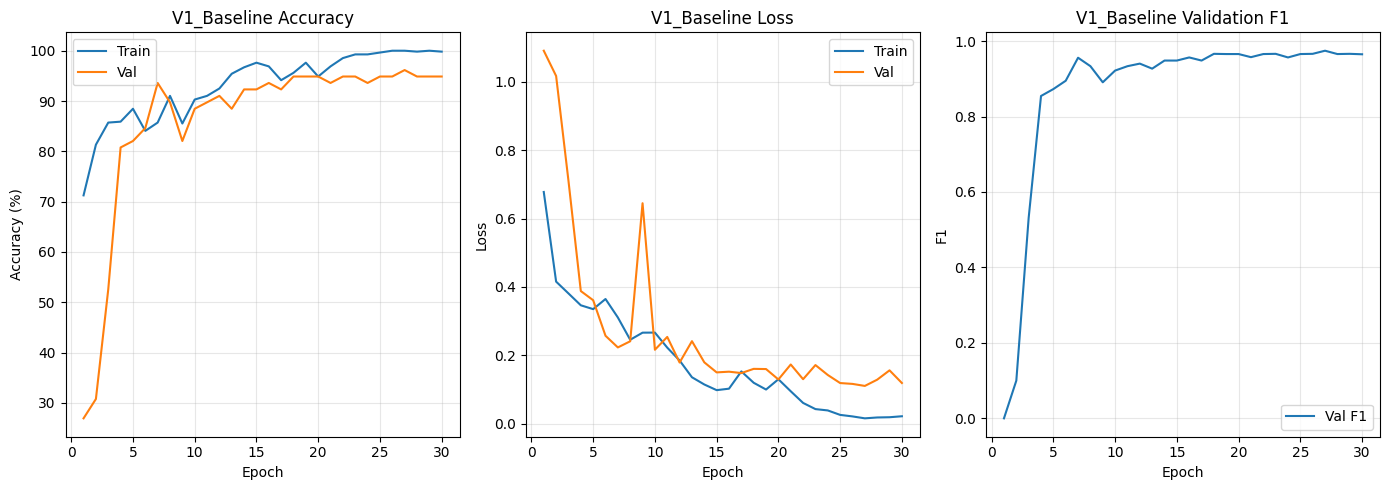

In [18]:
# Version 1: fc dropout = 0.3, no conv dropout
train_loader, val_loader, test_loader = make_loaders()
model, criterion, optimizer = setup_experiment(c_drop = 0.0, f_drop = 0.3, w_decay = 1e-4)
train_model(model, optimizer, criterion, "V1_Baseline", use_scheduler = False)

Version 1 shows the model learning the data effectively. Training accuracy ramps up quickly to 100%, showing it fits the training set very well, while validation accuracy and F1 improve more gradually, reflecting real generalization. The F1 score, balancing precision and recall, peaks at 0.974, indicating the model is both highly sensitive and specific for detecting the positive class. Early on, there is clear overfitting, with high training accuracy but poor validation performance, but by mid-training the validation metrics catch up, showing the model benefits from gradual learning. Overall, the model performs strongly with a good balance between precision and recall. The late-stage training curves hint that a bit of overfitting still remains, suggesting there could be room to experiment with slightly higher dropout rates to improve generalization further.

### Number of parameters

In [19]:
# These will be the same for all subsequent models as well (architecture will be the same)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Total trainable parameters:", count_parameters(model))

print("\nParameters by layer:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name:30s} {param.numel():>10}")

Total trainable parameters: 101730

Parameters by layer:
conv1.weight                          144
conv1.bias                             16
bn1.weight                             16
bn1.bias                               16
conv2.weight                         4608
conv2.bias                             32
bn2.weight                             32
bn2.bias                               32
conv3.weight                        18432
conv3.bias                             64
bn3.weight                             64
bn3.bias                               64
conv4.weight                        73728
conv4.bias                            128
bn4.weight                            128
bn4.bias                              128
fc.weight                            4096
fc.bias                                 2


### Model 2

Training V2_Stronger_FC...
--------------------------------------------------------------------------------------------------------------
Epoch 01 | Train acc:  72.9% Loss: 0.7002 | Val acc:  26.9% Loss: 1.2041 | P: 0.000 R: 0.000 F1: 0.000 
Epoch 02 | Train acc:  79.3% Loss: 0.4462 | Val acc:  30.8% Loss: 1.0125 | P: 1.000 R: 0.053 F1: 0.100 ✓ Saved
Epoch 03 | Train acc:  83.5% Loss: 0.4184 | Val acc:  57.7% Loss: 0.6600 | P: 0.962 R: 0.439 F1: 0.602 ✓ Saved
Epoch 04 | Train acc:  83.7% Loss: 0.3804 | Val acc:  80.8% Loss: 0.4061 | P: 0.977 R: 0.754 F1: 0.851 ✓ Saved
Epoch 05 | Train acc:  85.2% Loss: 0.3914 | Val acc:  74.4% Loss: 0.5290 | P: 0.930 R: 0.702 F1: 0.800 
Epoch 06 | Train acc:  84.4% Loss: 0.3619 | Val acc:  88.5% Loss: 0.2617 | P: 0.875 R: 0.982 F1: 0.926 ✓ Saved
Epoch 07 | Train acc:  86.3% Loss: 0.3143 | Val acc:  88.5% Loss: 0.2518 | P: 0.914 R: 0.930 F1: 0.922 
Epoch 08 | Train acc:  88.6% Loss: 0.2656 | Val acc:  87.2% Loss: 0.3195 | P: 0.851 R: 1.000 F1: 0.919 
Ep

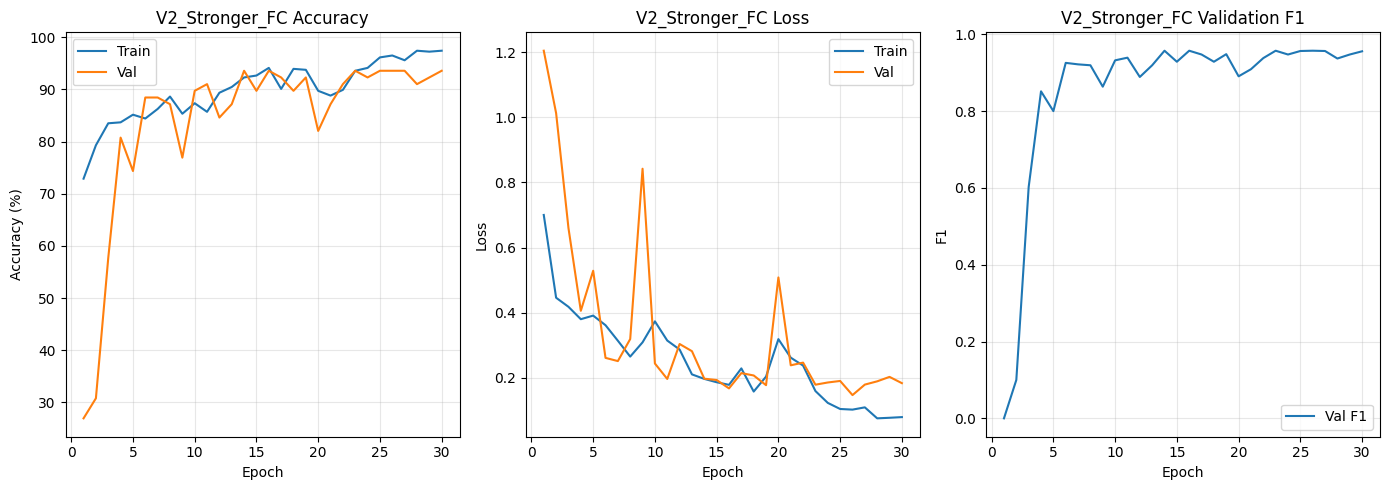

In [20]:
# Version 2: increase final dropout to stop high training accuracy
train_loader, val_loader, test_loader = make_loaders()
model, criterion, optimizer = setup_experiment(c_drop = 0.0, f_drop = 0.5, w_decay = 1e-4)
train_model(model, optimizer, criterion, "V2_Stronger_FC", use_scheduler = False)

Version 2, with stronger dropout in the fully connected layers, shows effective regularization compared with Version 1. Training accuracy rises steadily but not as quickly to 100%, indicating that the higher dropout is slowing memorization of the training set. Validation accuracy and F1 remain strong, peaking at 0.957, slightly below Version 1’s peak of 0.974, but the model exhibits less fluctuation between epochs, suggesting more stable generalization. Early overfitting is reduced compared with Version 1, as seen in the smaller gap between train and validation metrics in the mid-training epochs. Overall, the stronger FC dropout trades a small reduction in maximum F1 for a more controlled and stable training process, confirming that increasing dropout can help mitigate overfitting while still maintaining high sensitivity and specificity. This pattern motivates further tuning of dropout rates to find an optimal balance between performance and generalization.

### Model 3

Training V3_Medium_FC...
--------------------------------------------------------------------------------------------------------------
Epoch 01 | Train acc:  71.2% Loss: 0.6920 | Val acc:  26.9% Loss: 1.1302 | P: 0.000 R: 0.000 F1: 0.000 
Epoch 02 | Train acc:  79.7% Loss: 0.4330 | Val acc:  30.8% Loss: 0.9833 | P: 1.000 R: 0.053 F1: 0.100 ✓ Saved
Epoch 03 | Train acc:  83.3% Loss: 0.4282 | Val acc:  64.1% Loss: 0.5750 | P: 0.968 R: 0.526 F1: 0.682 ✓ Saved
Epoch 04 | Train acc:  83.3% Loss: 0.3796 | Val acc:  76.9% Loss: 0.4095 | P: 0.953 R: 0.719 F1: 0.820 ✓ Saved
Epoch 05 | Train acc:  85.7% Loss: 0.3675 | Val acc:  82.1% Loss: 0.4346 | P: 0.939 R: 0.807 F1: 0.868 ✓ Saved
Epoch 06 | Train acc:  87.2% Loss: 0.3348 | Val acc:  79.5% Loss: 0.3288 | P: 0.918 R: 0.789 F1: 0.849 
Epoch 07 | Train acc:  84.2% Loss: 0.3178 | Val acc:  91.0% Loss: 0.2668 | P: 0.931 R: 0.947 F1: 0.939 ✓ Saved
Epoch 08 | Train acc:  88.5% Loss: 0.2657 | Val acc:  89.7% Loss: 0.2428 | P: 0.889 R: 0.982 F1: 0.93

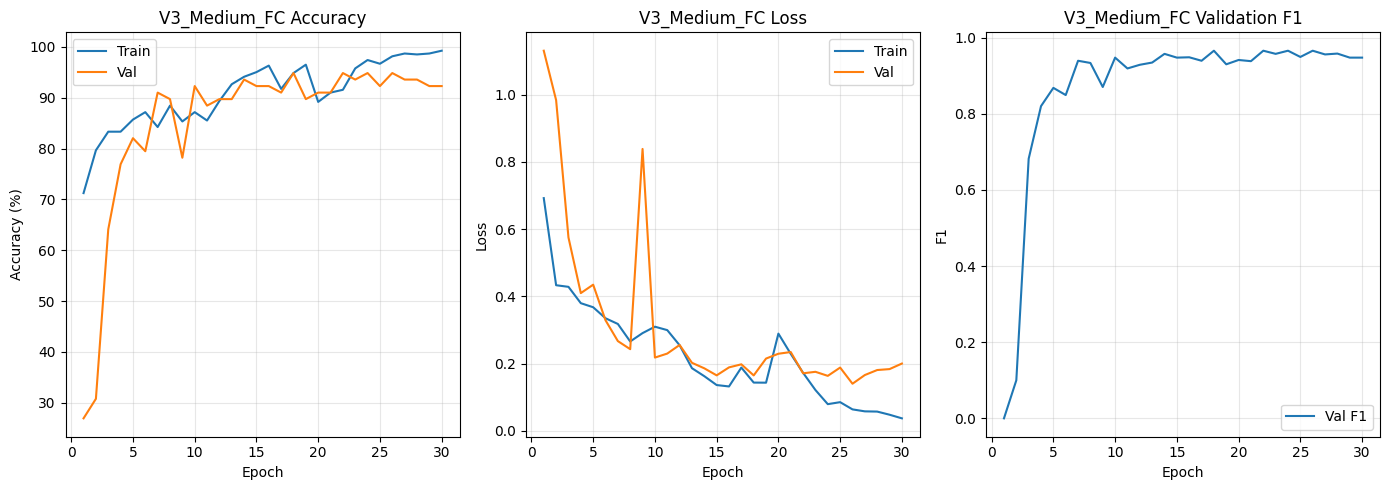

In [21]:
# Version 3: add internal conv dropout to stop the CNN from memorizing shapes
train_loader, val_loader, test_loader = make_loaders()
model, criterion, optimizer = setup_experiment(c_drop = 0.0, f_drop = 0.4, w_decay = 1e-4)
train_model(model, optimizer, criterion, "V3_Medium_FC", use_scheduler = False)

Version 3, with slightly medium FC dropout (0.4), shows that the model is learning effectively while slightly restraining overfitting. Training accuracy still climbs high but not as extremely as Version 1, and validation F1 peaks at 0.966, which is close to Version 1’s 0.974 and slightly above Version 2’s 0.957. Compared with Model 2, Model 3 recovers some of the F1 performance lost by increasing FC dropout in Version 2, indicating that 0.4 FC dropout still balances regularization with the model’s ability to learn discriminative features. The training and validation curves are smoother, suggesting more stable generalization, and early overfitting is less pronounced than Version 1.

Given these results, for Model 4, it makes sense to keep the FC dropout at 0.4, since it preserves strong F1 while controlling overfitting. For conv dropout, introducing a small value, around 0.1, is reasonable, as this could help prevent the CNN from memorizing shapes in the early convolutional layers without undercutting the learning of important spatial features. This would complement the FC dropout in controlling overfitting.

### Model 4

Training V4_Add_Conv...
--------------------------------------------------------------------------------------------------------------
Epoch 01 | Train acc:  71.2% Loss: 0.6732 | Val acc:  26.9% Loss: 0.9899 | P: 0.000 R: 0.000 F1: 0.000 
Epoch 02 | Train acc:  78.8% Loss: 0.5337 | Val acc:  52.6% Loss: 0.7056 | P: 0.917 R: 0.386 F1: 0.543 ✓ Saved
Epoch 03 | Train acc:  81.7% Loss: 0.5305 | Val acc:  64.1% Loss: 0.6545 | P: 0.872 R: 0.596 F1: 0.708 ✓ Saved
Epoch 04 | Train acc:  74.4% Loss: 0.5461 | Val acc:  73.1% Loss: 0.4834 | P: 0.950 R: 0.667 F1: 0.784 ✓ Saved
Epoch 05 | Train acc:  84.2% Loss: 0.4119 | Val acc:  79.5% Loss: 0.4043 | P: 0.936 R: 0.772 F1: 0.846 ✓ Saved
Epoch 06 | Train acc:  83.5% Loss: 0.3731 | Val acc:  84.6% Loss: 0.2825 | P: 0.881 R: 0.912 F1: 0.897 ✓ Saved
Epoch 07 | Train acc:  82.8% Loss: 0.4233 | Val acc:  74.4% Loss: 0.4286 | P: 0.930 R: 0.702 F1: 0.800 
Epoch 08 | Train acc:  80.0% Loss: 0.4479 | Val acc:  82.1% Loss: 0.3774 | P: 0.906 R: 0.842 F1: 0.873

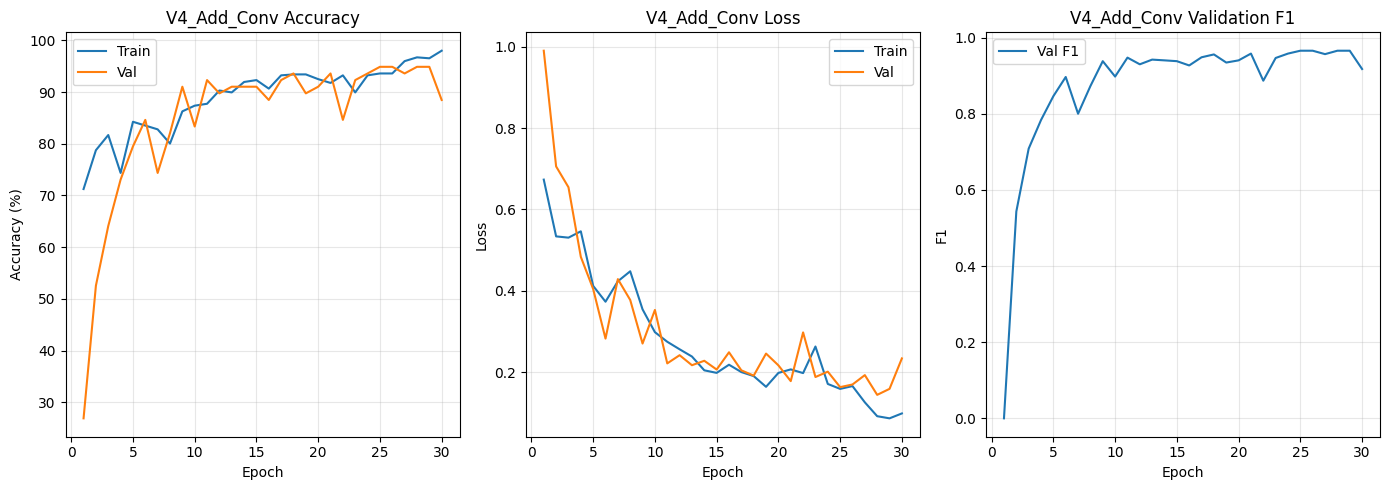

In [22]:
# Version 4: add conv dropout
train_loader, val_loader, test_loader = make_loaders()
model, criterion, optimizer = setup_experiment(c_drop = 0.1, f_drop = 0.4, w_decay = 1e-4)
train_model(model, optimizer, criterion, "V4_Add_Conv", use_scheduler = False)

Version 4, which adds a small conv dropout (0.1) on top of the previously effective FC dropout (0.4), demonstrates that the model can still learn well while slightly reducing memorization of local spatial features. Training accuracy again climbs high, indicating the model fits the training data, but validation accuracy is slightly lower than Models 1–3, reflecting the stronger regularization from the conv dropout. The validation F1 still peaks at 0.966, matching Model 3’s peak, which shows that the model retains strong balance between precision and recall despite the added conv dropout. Early training is more stable than Model 1, with less dramatic overfitting, and there is a smoother progression of F1 and precision/recall. Compared with Model 2, the conv dropout prevents some of the over-optimistic early F1 spikes, and relative to Model 3, it slightly lowers the final validation accuracy but maintains peak F1.

These results suggest that FC dropout of 0.4 and conv dropout of 0.1 is a strong combination for balancing learning capacity and generalization. For Model 5, the next logical step is to use this same dropout combination and introduce learning rate scheduling, which could help stabilize late training, mitigate minor overfitting seen in late epochs, and potentially improve final validation metrics without changing the model structure.

### Model 5

Training V5_Scheduler...
--------------------------------------------------------------------------------------------------------------
Epoch 01 | Train acc:  71.2% Loss: 0.6732 | Val acc:  26.9% Loss: 0.9899 | P: 0.000 R: 0.000 F1: 0.000 
Epoch 02 | Train acc:  78.8% Loss: 0.5337 | Val acc:  52.6% Loss: 0.7056 | P: 0.917 R: 0.386 F1: 0.543 ✓ Saved
Epoch 03 | Train acc:  81.7% Loss: 0.5305 | Val acc:  64.1% Loss: 0.6545 | P: 0.872 R: 0.596 F1: 0.708 ✓ Saved
Epoch 04 | Train acc:  74.4% Loss: 0.5461 | Val acc:  73.1% Loss: 0.4834 | P: 0.950 R: 0.667 F1: 0.784 ✓ Saved
Epoch 05 | Train acc:  84.2% Loss: 0.4119 | Val acc:  79.5% Loss: 0.4043 | P: 0.936 R: 0.772 F1: 0.846 ✓ Saved
Epoch 06 | Train acc:  83.5% Loss: 0.3731 | Val acc:  84.6% Loss: 0.2825 | P: 0.881 R: 0.912 F1: 0.897 ✓ Saved
Epoch 07 | Train acc:  82.8% Loss: 0.4233 | Val acc:  74.4% Loss: 0.4286 | P: 0.930 R: 0.702 F1: 0.800 
Epoch 08 | Train acc:  80.0% Loss: 0.4479 | Val acc:  82.1% Loss: 0.3774 | P: 0.906 R: 0.842 F1: 0.87

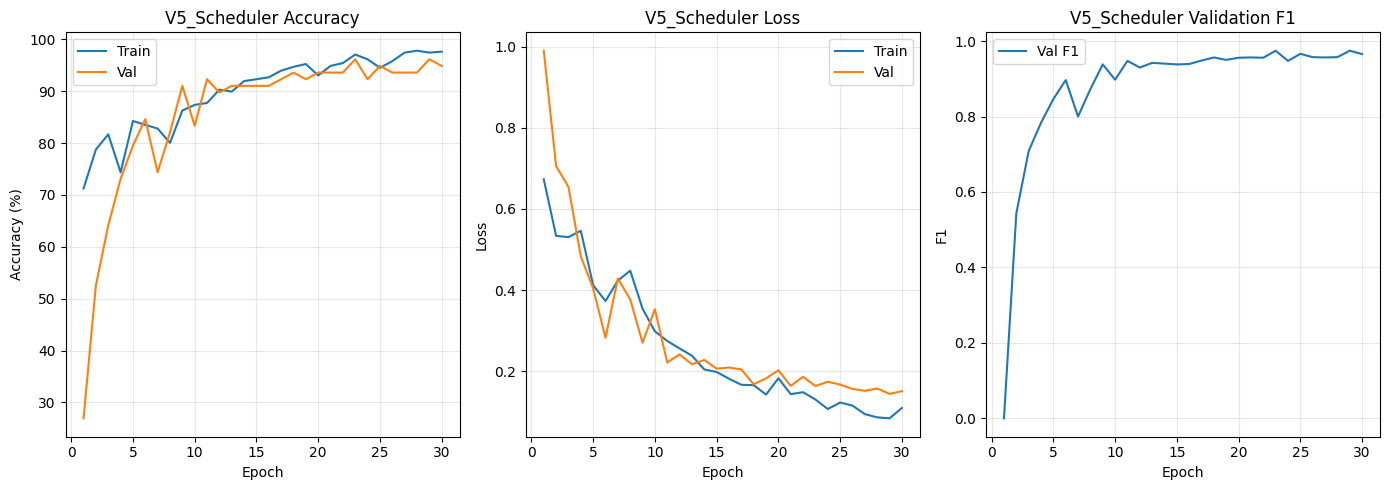

In [23]:
# Version 5: add scheduler
train_loader, val_loader, test_loader = make_loaders()
model, criterion, optimizer = setup_experiment(c_drop = 0.1, f_drop = 0.4, w_decay = 1e-4)
train_model(model, optimizer, criterion, "V5_Scheduler", use_scheduler = True)

Model 5 shows strong learning, building on the FC + conv dropout setup from previous models. Training accuracy again quickly climbs toward 100%, indicating the model can fit the training data extremely well. Validation metrics improve steadily, and the best validation F1 reaches 0.974, identical to the best score in Version 1 with similar architecture but no scheduler. Importantly, the learning rate scheduler is now active: it reduced the LR three times (1e-3 → 5e-4 → 2.5e-4 → 1.25e-4) at points where validation F1 plateaued. This confirms the scheduler is working and responding to plateaus, although the improvements in F1 after each LR drop are modest.

Compared to previous versions without a scheduler, Model 5 shows similar peak F1 and validation accuracy, suggesting that the original training was already near-optimal and the scheduler mainly helped fine-tune learning stability rather than producing large jumps in performance. The precision-recall balance remains excellent, with high recall throughout, indicating the model maintains sensitivity while minimizing false positives.

Going into Version 6, data augmentation is a logical next step: it should help the model generalize even further, potentially improving late-epoch stability and preventing any overfitting seen in the very high training accuracy epochs. The scheduler is already in place and will automatically adjust the learning rate if validation F1 plateaus again, so these improvements should be captured efficiently.

### Data augumentation

In [24]:
# Training transform with augmentation
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.RandomVerticalFlip(p = 0.5),
    transforms.RandomRotation(degrees = 10),
    transforms.RandomAffine(degrees = 0, translate = (0.1, 0.1)),
])

# Validation/test transform without augmentation
val_test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load datasets with appropriate transforms
train_dataset = BreastMNIST(split = 'train', download = True, size = 128, transform = train_transform)
val_dataset = BreastMNIST(split = 'val', download = True, size = 128, transform = val_test_transform)
test_dataset = BreastMNIST(split = 'test', download = True, size = 128, transform = val_test_transform)

### Model 6

Training V6_Augmentation...
--------------------------------------------------------------------------------------------------------------
Epoch 01 | Train acc:  70.5% Loss: 0.6576 | Val acc:  26.9% Loss: 0.8135 | P: 0.000 R: 0.000 F1: 0.000 
Epoch 02 | Train acc:  73.3% Loss: 0.5700 | Val acc:  78.2% Loss: 0.5122 | P: 0.778 R: 0.982 F1: 0.868 ✓ Saved
Epoch 03 | Train acc:  74.9% Loss: 0.5383 | Val acc:  75.6% Loss: 0.4772 | P: 0.896 R: 0.754 F1: 0.819 
Epoch 04 | Train acc:  75.8% Loss: 0.5888 | Val acc:  76.9% Loss: 0.4113 | P: 0.898 R: 0.772 F1: 0.830 
Epoch 05 | Train acc:  71.6% Loss: 0.6189 | Val acc:  76.9% Loss: 0.4751 | P: 0.915 R: 0.754 F1: 0.827 
Epoch 06 | Train acc:  76.9% Loss: 0.5160 | Val acc:  83.3% Loss: 0.4494 | P: 0.879 R: 0.895 F1: 0.887 ✓ Saved
Epoch 07 | Train acc:  74.7% Loss: 0.5169 | Val acc:  74.4% Loss: 0.5037 | P: 0.740 R: 1.000 F1: 0.851 
Epoch 08 | Train acc:  72.9% Loss: 0.5751 | Val acc:  80.8% Loss: 0.4154 | P: 0.792 R: 1.000 F1: 0.884 
Epoch 09 | Trai

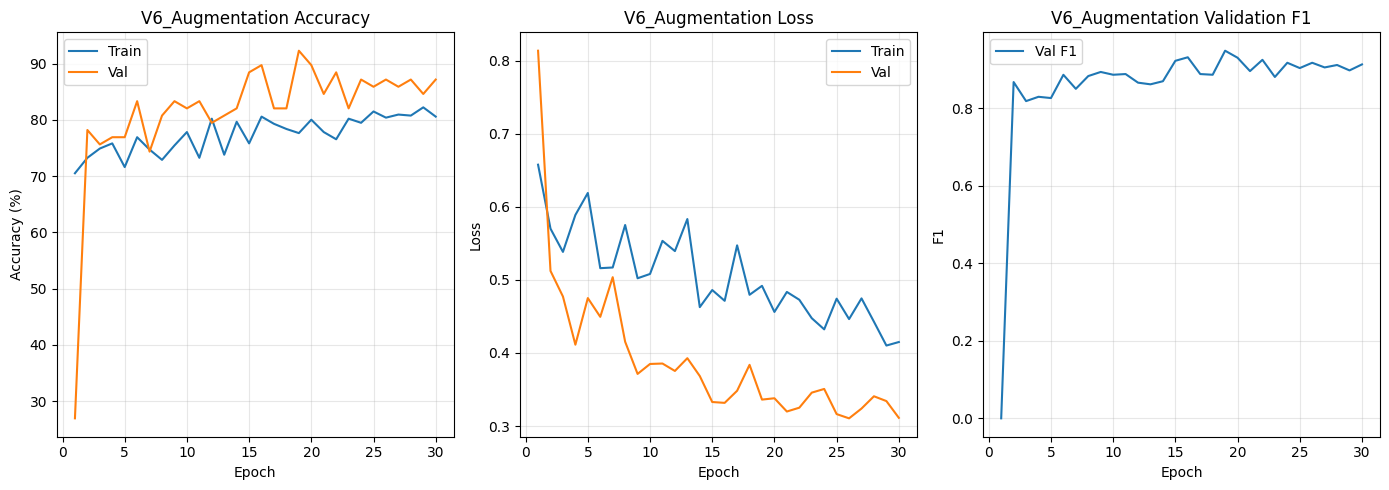

In [25]:
# Version 6: add data augmentation
train_loader, val_loader, test_loader = make_loaders()
model, criterion, optimizer = setup_experiment(c_drop = 0.1, f_drop = 0.4, w_decay = 1e-4)
train_model(model, optimizer, criterion, "V6_Augmentation", use_scheduler = True)

Version 6 incorporates data augmentation on top of the best FC + conv dropout combination (0.4 FC, 0.1 conv) and the learning rate scheduler. Training accuracy rises more gradually than in previous versions, stabilizing around 80–82%, as the augmented data makes the training distribution more challenging and prevents the model from memorizing individual samples.

Validation accuracy and F1 improve steadily, peaking at 0.949 for F1. This is slightly below the peak in Version 5 (0.974), but Version 6 shows stronger generalization early in training. Precision and recall remain solid (≈0.898 precision, ≈0.930 recall at the best epoch), reflecting good sensitivity while reducing overfitting, though not quite matching the highest metrics of earlier versions.

The learning rate scheduler is active and reduces the LR three times as validation F1 plateaued, confirming that it is functioning as intended.

Comparison to earlier versions:
- Reduced overfitting: Augmentation prevents the model from quickly hitting very high training accuracy (95–98%).
- Stable validation metrics: Slightly lower peaks, but better generalization potential for unseen data.
- Scheduler effective: LR drops occur at expected plateaus, helping fine-tune performance.

Overall, Version 6 trades a slightly lower peak F1 for better robustness and generalization due to data augmentation.

In [26]:
# List of saved model version names
model_versions = [
    "V1_Baseline",
    "V2_Stronger_FC",
    "V3_Medium_FC",
    "V4_Add_Conv",
    "V5_Scheduler",
    "V6_Augmentation"
]

# Helper function to evaluate a single model
def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim = 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average = "macro", zero_division = 0)
    rec = recall_score(all_labels, all_preds, average = "macro", zero_division = 0)
    f1 = f1_score(all_labels, all_preds, average = "macro", zero_division = 0)
    cm = confusion_matrix(all_labels, all_preds)

    return acc, prec, rec, f1, cm

# Evaluate all models
for version_name in model_versions:
    print(f"\nEvaluating {version_name}...")

    # Set architecture and notes
    if version_name == "V1_Baseline":
        c_drop, f_drop = 0.0, 0.3
        notes = "Baseline FC dropout"
    elif version_name == "V2_Stronger_FC":
        c_drop, f_drop = 0.0, 0.5
        notes = "Increased FC dropout"
    elif version_name == "V3_Medium_FC":
        c_drop, f_drop = 0.0, 0.4
        notes = "Medium FC dropout"
    elif version_name == "V4_Add_Conv":
        c_drop, f_drop = 0.1, 0.4
        notes = "Added conv dropout"
    elif version_name == "V5_Scheduler":
        c_drop, f_drop = 0.1, 0.4
        notes = "Scheduler used during training"
    elif version_name == "V6_Augmentation":
        c_drop, f_drop = 0.1, 0.4
        notes = "Scheduler + data augmentation used during training"

    # Setup model and load checkpoint
    model, _, _ = setup_experiment(c_drop = c_drop, f_drop = f_drop, w_decay = 1e-4)
    model.load_state_dict(torch.load(f"best_model_{version_name}.pth", map_location = device))
    model.to(device)

    acc, prec, rec, f1, cm = evaluate_model(model, test_loader)

    print(f"Notes: {notes}")
    print(f"Test accuracy: {acc:.4f}")
    print(f"Test precision (macro): {prec:.4f}")
    print(f"Test recall (macro): {rec:.4f}")
    print(f"Test F1 score (macro): {f1:.4f}")
    print("Confusion matrix:")
    print(cm)
    print("-" * 60)


Evaluating V1_Baseline...
Notes: Baseline FC dropout
Test accuracy: 0.8910
Test precision (macro): 0.8727
Test recall (macro): 0.8427
Test F1 score (macro): 0.8559
Confusion matrix:
[[ 31  11]
 [  6 108]]
------------------------------------------------------------

Evaluating V2_Stronger_FC...
Notes: Increased FC dropout
Test accuracy: 0.8590
Test precision (macro): 0.8265
Test recall (macro): 0.8058
Test F1 score (macro): 0.8151
Confusion matrix:
[[ 29  13]
 [  9 105]]
------------------------------------------------------------

Evaluating V3_Medium_FC...
Notes: Medium FC dropout
Test accuracy: 0.8590
Test precision (macro): 0.8306
Test recall (macro): 0.7982
Test F1 score (macro): 0.8120
Confusion matrix:
[[ 28  14]
 [  8 106]]
------------------------------------------------------------

Evaluating V4_Add_Conv...
Notes: Added conv dropout
Test accuracy: 0.8718
Test precision (macro): 0.8544
Test recall (macro): 0.8070
Test F1 score (macro): 0.8260
Confusion matrix:
[[ 28  14]
 [ 

## Results

### Final results comparison

| Version          | Notes                          | Test acc | Test prec | Test recall | Test F1 |
|------------------|--------------------------------|----------|-----------|-------------|---------|
| V1_Baseline      | Baseline FC dropout            |   0.8910 |    0.8727 |      0.8427 |  0.8559 |
| V2_Stronger_FC   | Increased FC dropout           |   0.8590 |    0.8265 |      0.8058 |  0.8151 |
| V3_Medium_FC     | Medium FC dropout              |   0.8590 |    0.8306 |      0.7982 |  0.8120 |
| V4_Add_Conv      | Added conv dropout             |   0.8718 |    0.8544 |      0.8070 |  0.8260 |
| V5_Scheduler     | Scheduler used during training |   0.8718 |    0.8544 |      0.8070 |  0.8260 |
| V6_Augmentation  | Scheduler + data augmentation  |   0.8333 |    0.8333 |      0.7206 |  0.7502 |

Summary:
The test F1 scores are noticeably lower than the peak validation F1 observed during training, particularly for versions with increased dropout or data augmentation. This indicates that the models were overfitting the training and validation sets to some extent, which is expected given the small dataset size. With limited samples, even high validation scores may not reliably reflect generalization, and small shifts in the test set can have a large effect on metrics like F1, especially for the minority or harder-to-classify class.

The test F1 results show that V1_Baseline achieves the highest balanced performance (0.856), despite strong overfitting during training. Accuracy is also highest for this version (0.891), and precision and recall remain relatively high, though the extreme training accuracy highlights overfitting. Increasing FC dropout in V2 and V3 reduced training overfit but lowered test F1, showing that too much regularization can harm generalization. Adding convolutional dropout (V4) or a learning rate scheduler (V5) slightly improved the balance between precision and recall without substantially changing test F1 compared to the baseline. Version 6, which combined data augmentation with the best FC + conv dropout, slowed training and reduced overfitting but achieved the lowest test F1 (0.750), reflecting a trade-off between robustness and peak performance.

For model selection in this medical imaging context, test F1 is the primary metric because it balances sensitivity (recall) and specificity (precision), both critical for accurate cancer detection. Accuracy, precision, and recall should also be reported for context, but the highest F1 model (V1_Baseline) is justified as the best-performing model on unseen data. If prioritizing robustness and generalization over peak performance, V4_Add_Conv or V5_Scheduler are reasonable alternatives, offering slightly more regularization with only minor drops in test F1.

Final chosen model: Model 1
